In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandahouse
import hashlib
from scipy import stats
from read_db.CH import Getch # коннектор для подключения к БД
%matplotlib inline

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220520'
}

In [3]:
q = """
SELECT exp_group, 
       user_id,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-24' and '2022-04-30'
      and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

group_A = df[df.exp_group == 2].copy()
group_B = df[df.exp_group == 1].copy()
#df.groupby('exp_group').count()

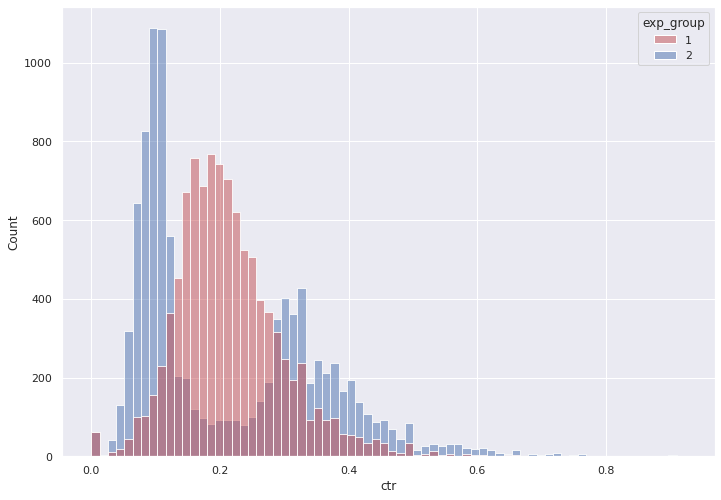

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)}) # Сделаем графики в seaborn покрупнее

# Нарисуем распределение
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Сразу заметно, что распределение ctr значительно изменилось

In [5]:
stats.ttest_ind(group_A.ctr,
                group_B.ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935)

Однако результат t-теста не позволяет утверждать, что между группами есть различие

In [6]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [7]:
global_ctr_A = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_B = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_A, global_ctr_B

(0.1980601844115994, 0.20802680490126244)

In [8]:
group_A['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_A, 5), axis=1)
group_B['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_B, 5), axis=1)

In [9]:
stats.ttest_ind(group_A.smoothed_ctr,
                group_B.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.0223769815558559)

А вот t-тест на сглаженном ctr уже показывает различие (p-value меньше 0.05)

In [10]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [11]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

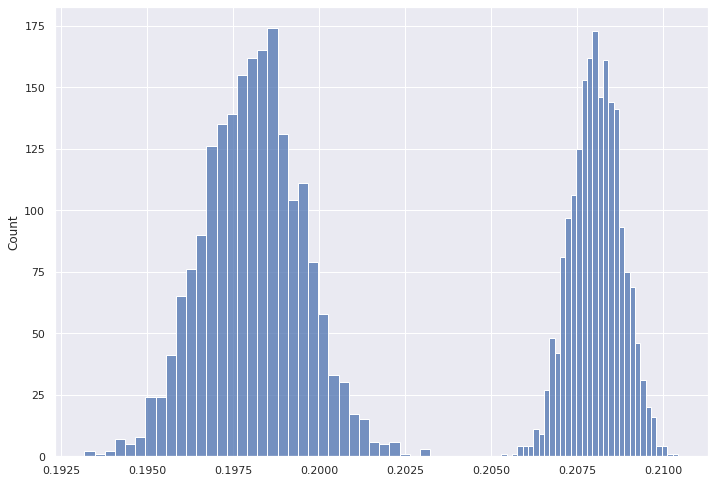

In [12]:
sns.histplot(ctr1)
sns.histplot(ctr2)

И по результатам применения пуассоновского бутстрепа видно значимое различие (распределения ctr'ов групп даже не пересекаются)

In [13]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Тест Манна-Уитни также видит различие

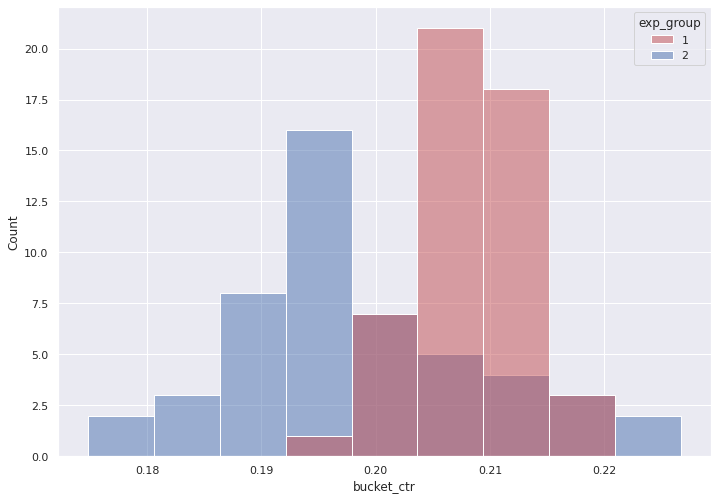

In [14]:
groups = sns.histplot(data = df, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На графике бакетного ctr также видно смещение ctr экспериментальной группы в меньшую сторону

Итого только t-test не показал различий в ctr, остальные же тесты позволяют утверждать, что общегрупповой ctr экспериментальной группы уменьшился относительно контрольной. В соответствии с тем, что мы изначально выбрали общегрупповой ctr в качестве метрики, увеличения которой мы хотим добиться, раскатывать новый алгоритм на всех новых пользователей нельзя. Однако стоит присмотреться к тому, что у части пользователей на графике распределения ctr видно его увеличение.